# Writing a training loop from scratch

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

## Introduction

Keras provides default training and evaluation loops, `fit()` and `evaluate()`.
Their usage is covered in the guide
[Training & evaluation with the built-in methods](https://www.tensorflow.org/guide/keras/train_and_evaluate/).

If you want to customize the learning algorithm of your model while still leveraging
the convenience of `fit()`
(for instance, to train a GAN using `fit()`), you can subclass the `Model` class and
implement your own `train_step()` method, which
is called repeatedly during `fit()`. This is covered in the guide
[Customizing what happens in `fit()`](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/).

Now, if you want very low-level control over training & evaluation, you should write
your own training & evaluation loops from scratch. This is what this guide is about.

## Using the `GradientTape`: a first end-to-end example

Calling a model inside a `GradientTape` scope enables you to retrieve the gradients of
the trainable weights of the layer with respect to a loss value. Using an optimizer
instance, you can use these gradients to update these variables (which you can
retrieve using `model.trainable_weights`).

Let's consider a simple MNIST model:

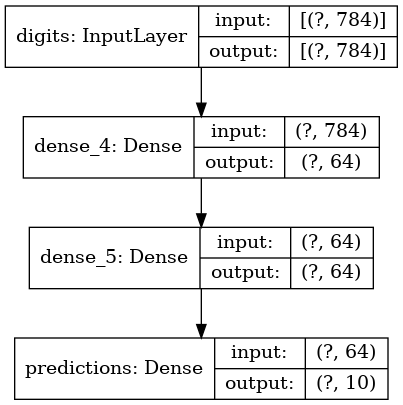

In [4]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu")(inputs)
x2 = layers.Dense(64, activation="relu")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(model, "../../../../learnMLData/img/gt_test.png", show_shapes=True)

Let's train it using mini-batch gradient with a custom training loop.

First, we're going to need an optimizer, a loss function, and a dataset:

In [5]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

Here's our training loop:

- We open a `for` loop that iterates over epochs
- For each epoch, we open a `for` loop that iterates over the dataset, in batches
- For each batch, we open a `GradientTape()` scope
- Inside this scope, we call the model (forward pass) and compute the loss
- Outside the scope, we retrieve the gradients of the weights
of the model with regard to the loss
- Finally, we use the optimizer to update the weights of the model based on the
gradients

In [6]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))


Start of epoch 0
Training loss (for one batch) at step 0: 131.1977
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.8868
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.7090
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.7975
Seen so far: 38464 samples

Start of epoch 1
Training loss (for one batch) at step 0: 0.4323
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.7409
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.9746
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.7309
Seen so far: 38464 samples


## Low-level handling of metrics

Let's add metrics monitoring to this basic loop.

You can readily reuse the built-in metrics (or custom ones you wrote) in such training
loops written from scratch. Here's the flow:

- Instantiate the metric at the start of the loop
- Call `metric.update_state()` after each batch
- Call `metric.result()` when you need to display the current value of the metric
- Call `metric.reset_states()` when you need to clear the state of the metric
(typically at the end of an epoch)

Let's use this knowledge to compute `SparseCategoricalAccuracy` on validation data at
the end of each epoch:

In [6]:
# Get model
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

Here's our training & evaluation loop:

In [7]:
import time

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 103.0367
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5581
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.2623
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.5200
Seen so far: 38464 samples
Training acc over epoch: 0.7642
Validation acc: 0.7968
Time taken: 4.62s

Start of epoch 1
Training loss (for one batch) at step 0: 1.2652
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.4405
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.7942
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4210
Seen so far: 38464 samples
Training acc over epoch: 0.8656
Validation acc: 0.8553
Time taken: 4.62s


## Speeding-up your training step with `tf.function`

The default runtime in TensorFlow 2.0 is
[eager execution](https://www.tensorflow.org/guide/eager). As such, our training loop
above executes eagerly.

This is great for debugging, but graph compilation has a definite performance
advantage. Describing your computation as a static graph enables the framework
to apply global performance optimizations. This is impossible when
the framework is constrained to greedly execute one operation after another,
with no knowledge of what comes next.

You can compile into a static graph any function that takes tensors as input.
Just add a `@tf.function` decorator on it, like this:

In [8]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value


Let's do the same with the evaluation step:

In [9]:
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)


Now, let's re-run our training loop with this compiled training step:

In [10]:
import time

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.5171
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.2827
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3070
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.4304
Seen so far: 38464 samples
Training acc over epoch: 0.8909
Validation acc: 0.8875
Time taken: 1.19s

Start of epoch 1
Training loss (for one batch) at step 0: 0.3593
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.5297
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.3933
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.1518
Seen so far: 38464 samples
Training acc over epoch: 0.9052
Validation acc: 0.9005
Time taken: 0.90s


Much faster, isn't it?

## Low-level handling of losses tracked by the model

Layers & models recursively track any losses created during the forward pass
by layers that call `self.add_loss(value)`. The resulting list of scalar loss
values are available via the property `model.losses`
at the end of the forward pass.

If you want to be using these loss components, you should sum them
and add them to the main loss in your training step.

Consider this layer, that creates an activity regularization loss:

In [11]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(1e-2 * tf.reduce_sum(inputs))
        return inputs


Let's build a really simple model that uses it:

In [12]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu")(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Here's what our training step should look like now:

In [13]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
        # Add any extra losses created during the forward pass.
        loss_value += sum(model.losses)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value


## Summary

Now you know everything there is to know about using built-in training loops and
writing your own from scratch.

To conclude, here's a simple end-to-end example that ties together everything
you've learned in this guide: a DCGAN trained on MNIST digits.

## End-to-end example: a GAN training loop from scratch

You may be familiar with Generative Adversarial Networks (GANs). GANs can generate new
images that look almost real, by learning the latent distribution of a training
dataset of images (the "latent space" of the images).

A GAN is made of two parts: a "generator" model that maps points in the latent
space to points in image space, a "discriminator" model, a classifier
that can tell the difference between real images (from the training dataset)
and fake images (the output of the generator network).

A GAN training loop looks like this:

1) Train the discriminator.
- Sample a batch of random points in the latent space.
- Turn the points into fake images via the "generator" model.
- Get a batch of real images and combine them with the generated images.
- Train the "discriminator" model to classify generated vs. real images.

2) Train the generator.
- Sample random points in the latent space.
- Turn the points into fake images via the "generator" network.
- Get a batch of real images and combine them with the generated images.
- Train the "generator" model to "fool" the discriminator and classify the fake images
as real.

For a much more detailed overview of how GANs works, see
[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

Let's implement this training loop. First, create the discriminator meant to classify
fake vs real digits:

In [14]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

Then let's create a generator network,
that turns latent vectors into outputs of shape `(28, 28, 1)` (representing
MNIST digits):

In [15]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

Here's the key bit: the training loop. As you can see it is quite straightforward. The
training step function only takes 17 lines.

In [16]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_images):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    return d_loss, g_loss, generated_images


Let's train our GAN, by repeatedly calling `train_step` on batches of images.

Since our discriminator and generator are convnets, you're going to want to
run this code on a GPU.

In [17]:
import os

# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 1  # In practice you need at least 20 epochs to generate nice digits.
save_dir = "./"

for epoch in range(epochs):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

        # Logging.
        if step % 200 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            # Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))

        # To limit execution time we stop after 10 steps.
        # Remove the lines below to actually train the model!
        if step > 10:
            break


Start epoch 0
discriminator loss at step 0: 0.70
adversarial loss at step 0: 0.69


That's it! You'll get nice-looking fake MNIST digits after just ~30s of training on the
Colab GPU.